# Install libraries

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, TFT, TSMixer, TSMixerx, NHITS, MLPMultivariate
from neuralforecast.losses.pytorch import MAE
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, mse


/venv/trading_bot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-31 19:45:29,852	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-03-31 19:45:29,953	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


# Load Data

In [4]:
# Load the preprocessed data
df = pd.read_csv('../ressource/dataset/data_2024_hour_preprocessed.csv', index_col=0)
print("Loaded preprocessed data with shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Loaded preprocessed data with shape: (8734, 15)

First few rows:
  unique_id                         ds    volume  trade_count         y  \
0   BTC/USD  2024-01-03 01:00:00+00:00  0.114760          4.0  0.095077   
1   BTC/USD  2024-01-03 02:00:00+00:00  0.788655          7.0  0.094449   
2   BTC/USD  2024-01-03 03:00:00+00:00  0.010126          5.0  0.094390   
3   BTC/USD  2024-01-03 04:00:00+00:00  0.004395          2.0  0.093120   
4   BTC/USD  2024-01-03 05:00:00+00:00  0.214889          2.0  0.093186   

   SMA_20_normalized  SMA_50_normalized  EMA_20_normalized  \
0           0.089027           0.067156           0.084302   
1           0.089087           0.068006           0.084654   
2           0.088925           0.068815           0.084967   
3           0.088488           0.069609           0.085125   
4           0.088107           0.070474           0.085275   

   BBL_20_2.0_normalized  BBM_20_2.0_normalized  BBU_20_2.0_normalized  \
0               0.093569             

In [5]:
# # Load Data
# df = df.reset_index()  # Reset index to access 'symbol'
# df = df.rename(columns={'timestamp': 'ds', 'close_normalized': 'y', 'symbol': 'unique_id'})

In [9]:
# Ensure 'ds' is a datetime object
df['ds'] = pd.to_datetime(df['ds'])

# Split Data (80% train, 20% test)
split_idx = int(0.8 * len(df))
df_train, df_test = df.iloc[:split_idx], df.iloc[split_idx:]

# We make validation and test splits
n_time = len(df_train.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)

In [10]:
horizon = 12  # Further reduced horizon to decrease memory usage
input_size = 32  # Further reduced input size to manage memory usage
models = [
      #     TSMixer(h=horizon,
      #           input_size=input_size,
      #           n_series=2,
      #           max_steps=200,  # Further reduced max_steps to limit memory consumption
      #           val_check_steps=20,  # Further reduced validation check steps
      #           early_stop_patience_steps=1,  # Further reduced early stop patience
      #           scaler_type='identity',
      #           valid_loss=MAE(),
      #           random_seed=12345678,
      #           ),
      #     MLPMultivariate(h=horizon,
      #           input_size=input_size,
      #           n_series=2,
      #           max_steps=200,  # Further reduced max_steps to limit memory consumption
      #           val_check_steps=20,  # Further reduced validation check steps
      #           early_stop_patience_steps=1,  # Further reduced early stop patience
      #           scaler_type='standard',
      #           hidden_size=32,  # Further reduced hidden size to manage memory usage
      #           valid_loss=MAE(),
      #           random_seed=12345678,
      #           ),                                             
           NHITS(h=horizon,
                input_size=horizon,
                max_steps=200,  # Further reduced max_steps to limit memory consumption
                val_check_steps=20,  # Further reduced validation check steps
                early_stop_patience_steps=1,  # Further reduced early stop patience
                scaler_type='robust',
                valid_loss=MAE(),
                random_seed=12345678,
                ),                                                                       
         ]

Seed set to 12345678


In [11]:
# Train a multivariate forecasting model with reduced batch size to manage memory
nf = NeuralForecast(
    models=models,
    freq='T',
)

# Set a smaller batch size to avoid out of memory errors
Y_hat_df = nf.cross_validation(
    df=df_train,
    val_size=val_size,
    test_size=test_size,
    n_windows=None,
    step_size=1,  # Adjust step size to reduce memory load
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | valid_loss   | MAE           | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable par

Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 39.44it/s, v_num=0, train_loss_step=3.780, train_loss_epoch=3.780, valid_loss=0.00972]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.66it/s]


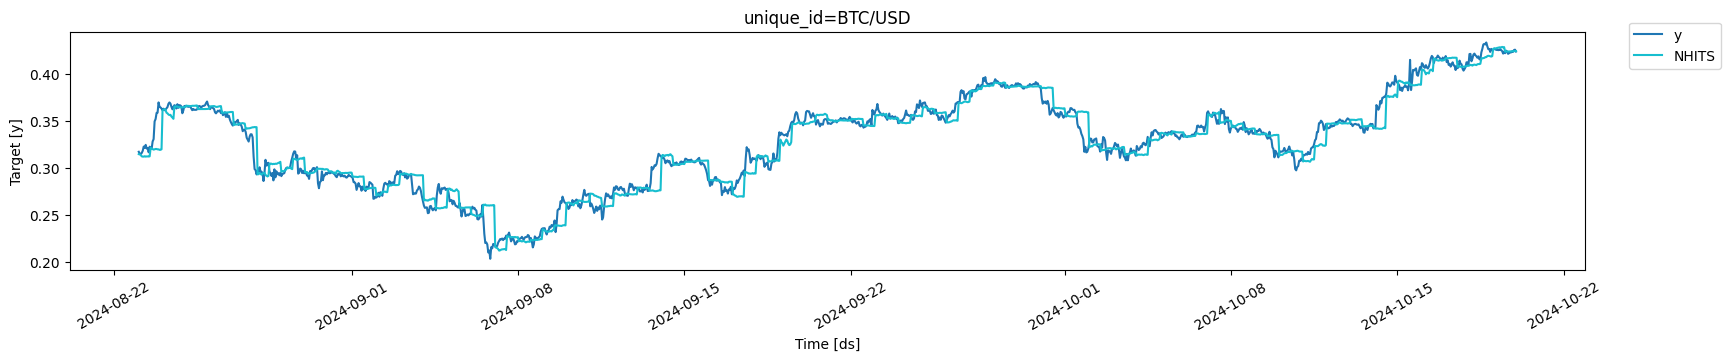

In [12]:
cutoffs = Y_hat_df['cutoff'].unique()[::horizon]
Y_plot = Y_hat_df[Y_hat_df['cutoff'].isin(cutoffs)].drop(columns='cutoff')
plot_series(forecasts_df=Y_plot, ids=['BTC/USD'])

In [13]:
evaluate(Y_hat_df.drop(columns='cutoff'), metrics=[mae, mse], agg_fn='mean')

,metric,NHITS
0,mae,0.006982
1,mse,0.000103


In [14]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# # Initialize lists to store predictions
# predictions = []
# actual_values = []
# timestamps = []

# # Select 500 random timestamps (ensuring index is at least 100)
# np.random.seed(42)  # For reproducibility
# random_indices = np.random.choice(range(100, len(df_test)), size=500, replace=False)

# for i in random_indices:
#     df_input = df_test.iloc[i-100:i].copy()  # Take last 100 timestamps

#     # Make prediction (assuming nf.predict() works with this input format)
#     pred = nf.predict(df_input)

#     # Store the prediction, actual value, and timestamp
#     predictions.append(pred.iloc[-1]["NHITS"])  # Predicted next value
#     actual_values.append(df_test.iloc[i]["y"])   # Actual next value
#     timestamps.append(df_test.iloc[i]["ds"])     # Corresponding timestamp

In [15]:
# # Convert results to DataFrame
# df_results = pd.DataFrame({"ds": timestamps, "y_pred": predictions, "y_actual": actual_values})

# # Compute evaluation metrics
# mae = mean_absolute_error(df_results["y_actual"], df_results["y_pred"])
# mse = mean_squared_error(df_results["y_actual"], df_results["y_pred"])

# # Print metrics
# print(f"MAE: {mae:.6f}")
# print(f"MSE: {mse:.6f}")

# # Plot actual vs. predicted values
# plt.figure(figsize=(10, 5))
# plt.plot(df_results["ds"], df_results["y_actual"], label="Actual", color="blue")
# plt.plot(df_results["ds"], df_results["y_pred"], label="Predicted", color="red", linestyle="dashed")
# plt.xlabel("Time")
# plt.ylabel("Normalized Price")
# plt.title("Actual vs. Predicted Price (500 Random Timestamps)")
# plt.legend()
# plt.xticks(rotation=45)
# plt.show()


In [16]:
import joblib

# Save the model to a file
joblib.dump(nf, '../ressource/models/prediction_model.pkl')

['../ressource/models/prediction_model.pkl']

In [ ]:
import joblib

# Load the model from the file
nf = joblib.load('ressource/models/prediction_model.pkl')